In [46]:
import dill
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume

from moo.enroads_problem import EnroadsProblem
from enroads_runner import EnroadsRunner
from evolution.outcomes.outcome_manager import OutcomeManager

## Setup

In [47]:
save_path = "results/pymoo/firsttry"
with open(save_path + "/config.json", 'r') as f:
    config = json.load(f)

actions = config["actions"]
outcomes = config["outcomes"]

with open("results/pymoo/firsttry/results", 'rb') as f:
    res = dill.load(f)
    print("Loaded Checkpoint:", res)

X = res.X
F = res.F

# NOTE: Don't use the problem to evaluate because we might run into concurrency issues with read/write.
problem = EnroadsProblem(actions, outcomes)
runner = EnroadsRunner("experiments/temp")
baseline_df = runner.evaluate_actions({})
outcome_manager = OutcomeManager(list(outcomes.keys()))
baseline_metrics = outcome_manager.process_outcomes({}, baseline_df)

Loaded Checkpoint: <pymoo.core.result.Result object at 0x1233be860>
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.


## Convergence Check

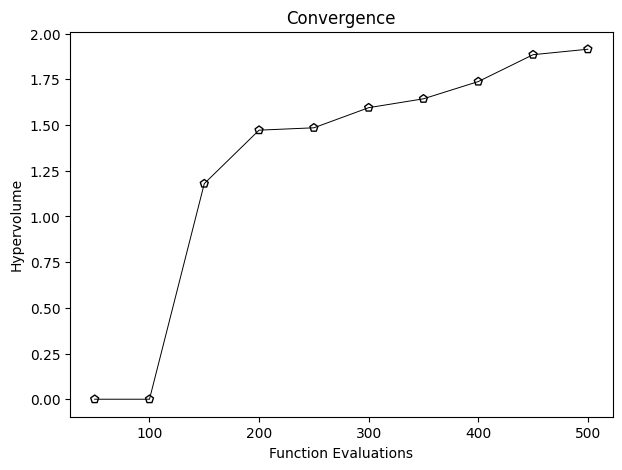

In [48]:
def extract_history(res):
    hist = res.history
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    return n_evals, hist_F, hist_cv, hist_cv_avg

n_evals, hist_F, hist_cv, hist_cv_avg = extract_history(res)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

metric = Hypervolume(ref_point=approx_nadir+1,
                     norm_ref_point=True,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

## Objectives

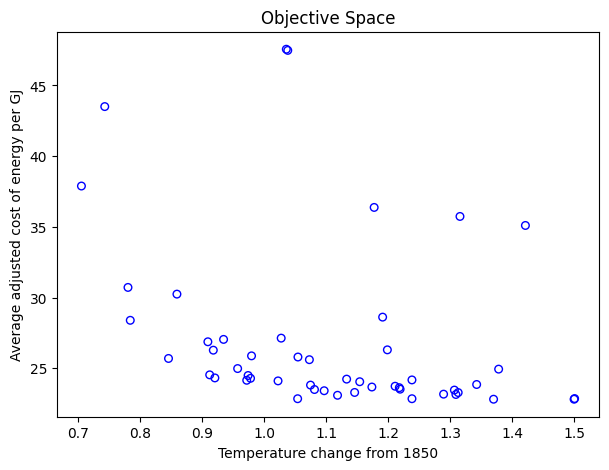

In [49]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("Temperature change from 1850")
plt.ylabel("Average adjusted cost of energy per GJ")
plt.show()

In [50]:
sample_idxs = set()
for i in range(F.shape[1]):
    sample_idxs.add(F[:,i].argmin())
    sample_idxs.add(F[:,i].argmax())

sample_idxs = list(sample_idxs)
sample_idxs

[np.int64(0), np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7)]

In [51]:
def plot_parallel_coordinates(F, outcomes, cand_idxs):
    coords_dicts = []
    for cand_idx in range(F.shape[0]):
        results_dict = dict(zip(outcomes.keys(), F[cand_idx]))
        if cand_idx in cand_idxs:
            print(results_dict)
        # Since we always minimize we need to flip the sign of outcomes that are maximized.
        for key in results_dict:
            if not outcomes[key]:
                results_dict[key] = -results_dict[key]
        if cand_idx in cand_idxs:
            results_dict["cand_id"] = cand_idx
        else:
            results_dict["cand_id"] = "other"
        coords_dicts.append(results_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "other"], "cand_id", color=["lightgray"])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    condition = (normalized_df["cand_id"] != "other") & (normalized_df["cand_id"] != "Baseline")
    pd.plotting.parallel_coordinates(normalized_df[condition], "cand_id", color=colors)

    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "Baseline"], "cand_id", color="black")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

{'Temperature above 1.5C': np.float64(0.7052200000000002), 'Max cost of energy': np.float64(37.8899), 'Government net revenue below zero': np.float64(0.0), 'Total energy below baseline': np.float64(15335.151999999998)}
{'Temperature above 1.5C': np.float64(1.36972), 'Max cost of energy': np.float64(22.8157), 'Government net revenue below zero': np.float64(12.043006250000001), 'Total energy below baseline': np.float64(1942.2649999999999)}
{'Temperature above 1.5C': np.float64(1.50039), 'Max cost of energy': np.float64(22.8622), 'Government net revenue below zero': np.float64(0.0), 'Total energy below baseline': np.float64(2508.1459999999997)}
{'Temperature above 1.5C': np.float64(0.8456100000000002), 'Max cost of energy': np.float64(25.6979), 'Government net revenue below zero': np.float64(88.55864050000002), 'Total energy below baseline': np.float64(17936.348999999995)}
{'Temperature above 1.5C': np.float64(1.17352), 'Max cost of energy': np.float64(23.6787), 'Government net revenue be

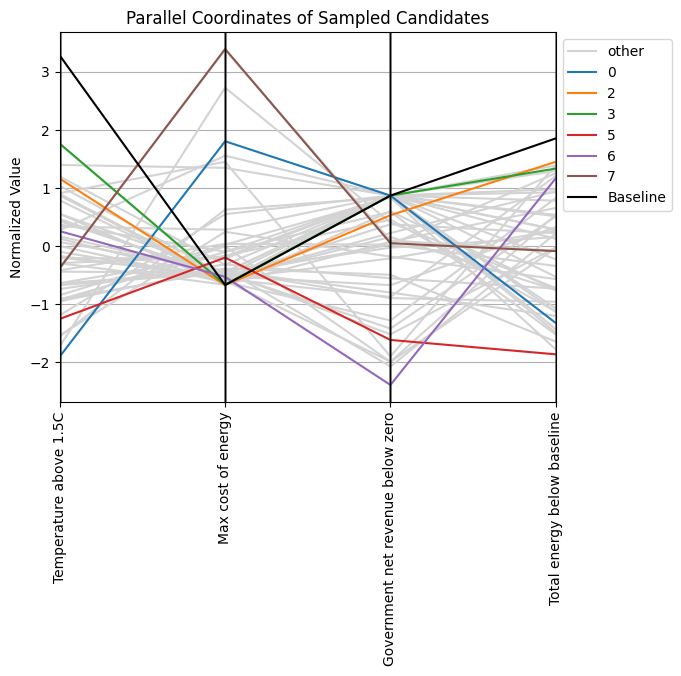

In [52]:
plot_parallel_coordinates(F, outcomes, sample_idxs)

## Outcomes

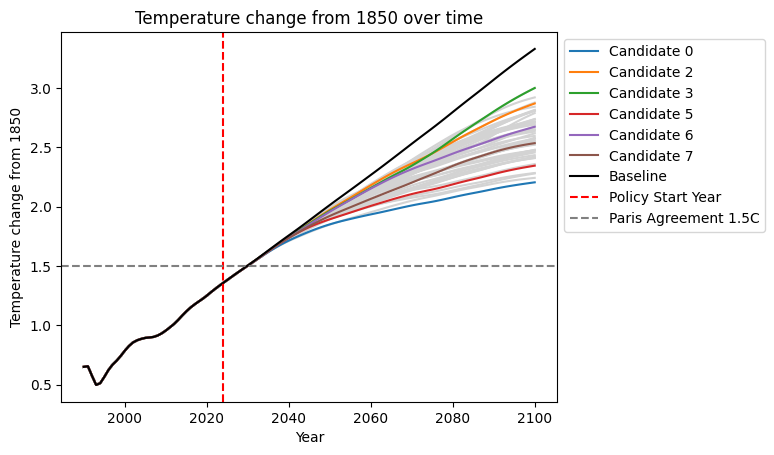

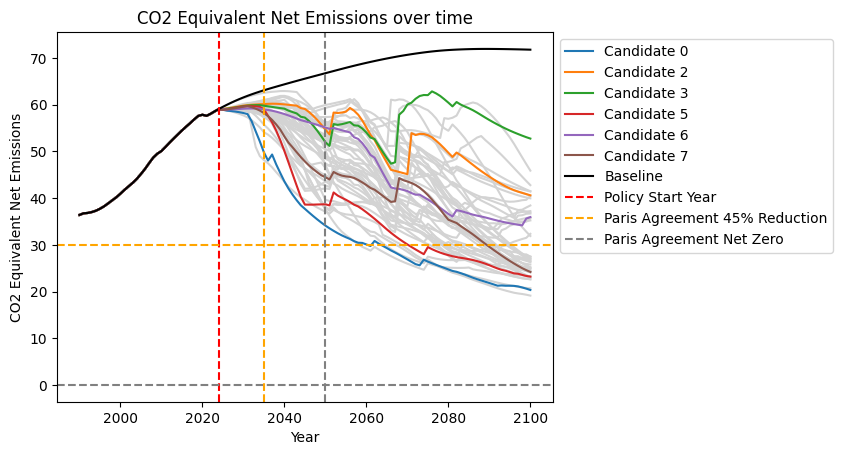

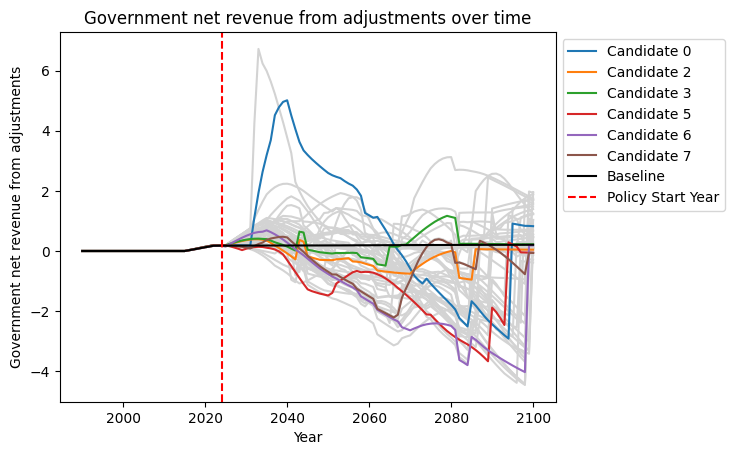

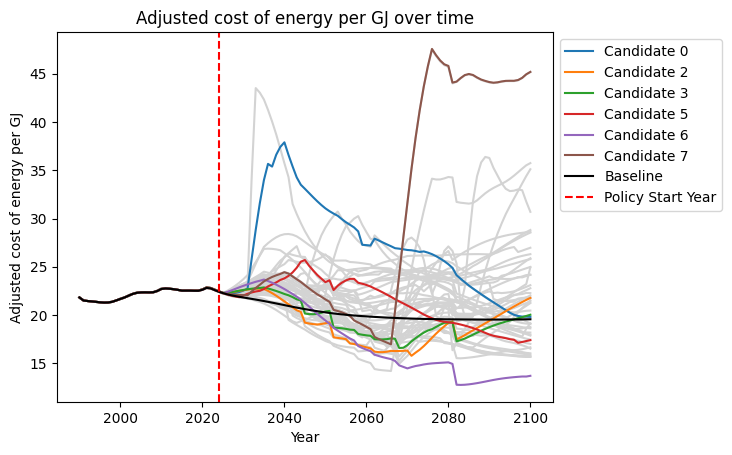

In [62]:
def plot_outcome_over_time(outcomes: list[str], cand_idxs: list[int], X: np.ndarray, problem: EnroadsProblem, runner: EnroadsRunner, baseline_df):
    outcomes_dfs = []
    for cand_idx in range(X.shape[0]):
        actions_dict = problem.params_to_actions_dict(X[cand_idx])
        outcomes_df = runner.evaluate_actions(actions_dict)
        outcomes_dfs.append(outcomes_df)

    for outcome in outcomes:
        for cand_idx in range(X.shape[0]):
            if cand_idx not in cand_idxs:
                plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], color="lightgray")
        for cand_idx in cand_idxs:
            plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], label=f"Candidate {cand_idx}")
        plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
        plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

        if outcome == "CO2 Equivalent Net Emissions":
            plt.axhline(y=0, color="gray", linestyle="--")
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

        elif outcome == "Temperature change from 1850":
            plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

        plt.legend(bbox_to_anchor=(1, 1))
        plt.title(f"{outcome} over time")
        plt.xlabel("Year")
        plt.ylabel(outcome)
        plt.show()

plot_outcomes = ["Temperature change from 1850", "CO2 Equivalent Net Emissions", "Government net revenue from adjustments", "Adjusted cost of energy per GJ"]
plot_outcome_over_time(plot_outcomes, sample_idxs, X, problem, runner, baseline_df)